In [4]:
import numpy as np
import tensorflow as tf 
from tensorflow.contrib.seq2seq import dynamic_decode

In [ ]:
from infolog import log
from tacotron.utils.symbols import symbols
from tacotron.models.custom_decoder import CustomDecoder
from tacotron.models.attention import LocationSensitiveAttention
from tacotron.models.helpers import TacoTrainingHelper, TacoTestHelper
from tacotron.models.modules import *
from tacotron.models.Architecture_wrappers import TacotronEncoderCell, TacotronDecoderCell

In [ ]:
def split_func(x, split_pos):
    rst = []
    start = 0
    # x will be a numpy array with the contents of the placeholder below
    for i in range(split_pos.shape[0]):
        rst.append(x[:,start:start+split_pos[i]])
        start += split_pos[i]
    return rst

In [ ]:
class Tacotron():
    """Tacotron-2 Feature prediction Model.
    """
    def __init__(self, hparams):
        self._hparams = hparams

    def initialize(self, inputs, input_lengths, mel_targets=None, stop_token_targets=None, linear_targets=None, targets_lengths=None, gta=False,
            global_step=None, is_training=False, is_evaluating=False, split_infos=None):
        """
        Initializes the model for inference
        sets "mel_outputs" and "alignments" fields.
        Args:
            - inputs: int32 Tensor with shape [N, T_in] where N is batch size, T_in is number of
              steps in the input time series, and values are character IDs
            - input_lengths: int32 Tensor with shape [N] where N is batch size and values are the lengths
            of each sequence in inputs.
            - mel_targets: float32 Tensor with shape [N, T_out, M] where N is batch size, T_out is number
            of steps in the output time series, M is num_mels, and values are entries in the mel
            spectrogram. Only needed for training.
        """
        if mel_targets is None and stop_token_targets is not None:
            raise ValueError('no multi targets were provided but token_targets were given')
        if mel_targets is not None and stop_token_targets is None and not gta:
            raise ValueError('Mel targets are provided without corresponding token_targets')
        if not gta and self._hparams.predict_linear==True and linear_targets is None and is_training:
            raise ValueError('Model is set to use post processing to predict linear spectrograms in training but no linear targets given!')
        if gta and linear_targets is not None:
            raise ValueError('Linear spectrogram prediction is not supported in GTA mode!')
        if is_training and self._hparams.mask_decoder and targets_lengths is None:
            raise RuntimeError('Model set to mask paddings but no targets lengths provided for the mask!')
        if is_training and is_evaluating:
            raise RuntimeError('Model can not be in training and evaluation modes at the same time!')
            
        split_device = '/cpu:0' if self._hparams.tacotron_num_gpus > 1 or self._hparams.split_on_cpu else '/gpu:0'

In [ ]:
        with tf.device(split_device):
            hp = self._hparams
            lout_int = [tf.int32]*hp.tacotron_num_gpus
            lout_float = [tf.float32]*hp.tacotron_num_gpus

            tower_input_lengths = tf.split(input_lengths, num_or_size_splits=hp.tacotron_num_gpus, axis=0)
            tower_targets_lengths = tf.split(targets_lengths, num_or_size_splits=hp.tacotron_num_gpus, axis=0) if targets_lengths is not None else targets_lengths

            p_inputs = tf.py_func(split_func, [inputs, split_infos[:, 0]], lout_int)
            p_mel_targets = tf.py_func(split_func, [mel_targets, split_infos[:,1]], lout_float) if mel_targets is not None else mel_targets
            p_stop_token_targets = tf.py_func(split_func, [stop_token_targets, split_infos[:,2]], lout_float) if stop_token_targets is not None else stop_token_targets
            p_linear_targets = tf.py_func(split_func, [linear_targets, split_infos[:,3]], lout_float) if linear_targets is not None else linear_targets

            tower_inputs = []
            tower_mel_targets = []
            tower_stop_token_targets = []
            tower_linear_targets = []

            batch_size = tf.shape(inputs)[0]
            mel_channels = hp.num_mels
            linear_channels = hp.num_freq
            for i in range (hp.tacotron_num_gpus):
                tower_inputs.append(tf.reshape(p_inputs[i], [batch_size, -1]))
                if p_mel_targets is not None:
                    tower_mel_targets.append(tf.reshape(p_mel_targets[i], [batch_size, -1, mel_channels]))
                if p_stop_token_targets is not None:
                    tower_stop_token_targets.append(tf.reshape(p_stop_token_targets[i], [batch_size, -1]))
                if p_linear_targets is not None:
                    tower_linear_targets.append(tf.reshape(p_linear_targets[i], [batch_size, -1, linear_channels]))

        T2_output_range = (-hp.max_abs_value, hp.max_abs_value) if hp.symmetric_mels else (0, hp.max_abs_value)

        self.tower_decoder_output = []
        self.tower_alignments = []
        self.tower_stop_token_prediction = []
        self.tower_mel_outputs = []
        self.tower_linear_outputs = []

        tower_embedded_inputs = []
        tower_enc_conv_output_shape = []
        tower_encoder_outputs = []
        tower_residual = []
        tower_projected_residual = []

#### tf.py_func

这是一个可以把 TensorFlow 和 Python 原生代码无缝衔接起来的函数，有了它，你就可以在 TensorFlow 里面自由的实现你想要的功能，而不用考虑 TensorFlow 有没有实现它的 API，并且可以帮助我们实现自由的检查该功能模块的输入输出是否正确，而不受到TensorFlow 的先构造计算图再运行导致的不能单独检测单一模块的功能的限制；

它的具体功能描述是**包装一个普通的 Python 函数，这个函数接受 numpy 的数组作为输入和输出，让这个函数可以作为 TensorFlow 计算图上的计算节点 OP 来使用**。

```
py_func(func, inp, Tout, stateful=True, name=None)
```

参数：

- 一个 Python 函数, 它接受 NumPy 数组作为输入和输出，并且数组的类型和大小必须和输入和输出用来衔接的 Tensor 大小和数据类型相匹配.

- inp: 输入的 Tensor 列表.

- Tout: 输出 Tensor 数据类型的列表或元祖.

- stateful: boolean

- name: 节点op的名称

**缺点：**

这个被包装过的的计算函数的内部部分不会被序列化到 GraphDef 里面去，所以，如果你要序列化存储和恢复模型，就不能使用该函数。
这个被包装的计算节点 OP 与调用它的 Python 程序必须运行在同一个物理设备上，也就是说，如果使用分布式TensorFlow，必须使用 tf.train.Server 和 with tf.device(): 来保证二者在同一个服务器内。

```
import tensorflow as tf

def add(x,y):
     return x+y,x-y,x.dot(y)

a = [[1,2],[3,4]]
b = [[1,2],[1,1]]
x = tf.placeholder(tf.float32,(2,2))
y = tf.placeholder(tf.float32,(2,2))
result1,result2,result3 = tf.py_func(add, [x,y], [tf.float32,tf.float32,tf.float32])

with tf.Session as sess:
    sess.run(tf.global_varbles_initializer())
    s1,s2,s3 = sess.run([result1,result2,result3],feed_dict = {x:a,y:b})
    print(s1,s2,s3)
```

### Character Embedding

In [ ]:
        # 1. Declare GPU Devices
        gpus = [f"/gpu:{i}" for i in range(hp.tacotron_num_gpus)]
        for i in range(hp.tacotron_num_gpus):
            with tf.device(tf.train.replica_device_setter(ps_tasks=1, ps_device="/cpu:0", worker_device=gpus[i])):
                with tf.variable_scope('inference') as scope:
                    assert hp.tacotron_teacher_forcing_mode in ('constant', 'scheduled')
                    if hp.tacotron_teacher_forcing_mode == 'scheduled' and is_training:
                        assert global_step is not None

                    #GTA is only used for predicting mels to train Wavenet vocoder, so we ommit post processing when doing GTA synthesis
                    post_condition = hp.predict_linear and not gta

                    # Embeddings ==> [batch_size, sequence_length, embedding_dim]
                    self.embedding_table = tf.get_variable('inputs_embedding', [len(symbols), hp.embedding_dim], dtype=tf.float32)
                    embedded_inputs = tf.nn.embedding_lookup(self.embedding_table, tower_inputs[i])

### Encoder Block

Encoder部分是由TacotronEncoderCell类表示的，里面包含了EncoderConvolutions卷积和 EncoderRNN(lstm)循环网络，TacotronEncoderCell在`./Architecture_wrapper.ipynb`中。EncoderConvolutions和EncoderRNN在`./modules.ipynb`

具体内容看 ：

- `./Architecture_wrappers.ipynb` http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/Architecture_wrappers.ipynb

-  `./modules.ipynb` http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/modules.ipynb

Passes inputs through a stack of convolutional layers (3 layers, kernel_size=5, channel=512, dropout_rate=0.5, relu,在激活函数之后用batch_norm) then through a bidirectional LSTM layer(zoneout instead of dropout) to predict the hidden representation vector

In [ ]:
                    #Encoder Cell ==> [batch_size, encoder_steps, encoder_lstm_units]
                    encoder_cell = TacotronEncoderCell(
                        EncoderConvolutions(is_training, hparams=hp, scope='encoder_convolutions'),
                        EncoderRNN(is_training, size=hp.encoder_lstm_units,
                            zoneout=hp.tacotron_zoneout_rate, scope='encoder_LSTM'))

                    encoder_outputs = encoder_cell(embedded_inputs, tower_input_lengths[i])
                    
                    #For shape visualization purpose
                    enc_conv_output_shape = encoder_cell.conv_output_shape

### Decoder Block

Tacotron2的Decoder部分是由以下五部分构成：

1. [Prenet](http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/modules.ipynb) ： 2层Fc全连接

2. [LocationSensitiveAttention](http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/attention.ipynb)

3. LSTM：两层ZoneOutLSTM组成 [DecoderRNN](http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/modules.ipynb)

4. [FrameProjection](http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/modules.ipynb): 1层Dense , no activation, 为了调整输出维度

5. [StopProjection](http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/modules.ipynb) : 1层Dense, activation = sigmoid

decoder是一个自回归RNN，它从encoder的输入序列预测输出声谱图，一次预测一帧。


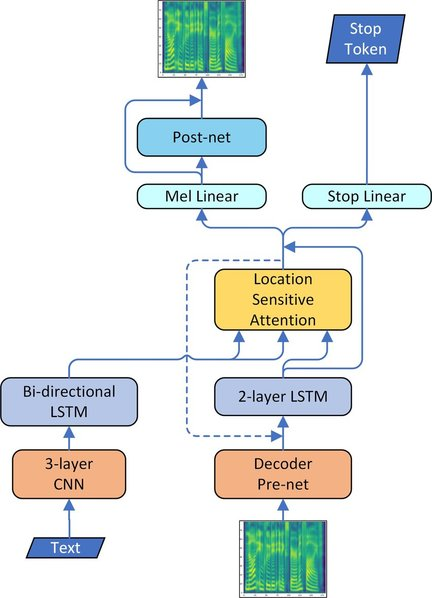

In [ ]:
                    #Decoder Parts
                    #Attention Decoder Prenet
                    prenet = Prenet(is_training, layers_sizes=hp.prenet_layers, drop_rate=hp.tacotron_dropout_rate, scope='decoder_prenet')
                    
                    #Attention Mechanism
                    attention_mechanism = LocationSensitiveAttention(hp.attention_dim, encoder_outputs, hparams=hp, is_training=is_training,
                        mask_encoder=hp.mask_encoder, memory_sequence_length=tf.reshape(tower_input_lengths[i], [-1]), smoothing=hp.smoothing,
                        cumulate_weights=hp.cumulative_weights)
                    
                    #Decoder LSTM Cells
                    decoder_lstm = DecoderRNN(is_training, layers=hp.decoder_layers,
                        size=hp.decoder_lstm_units, zoneout=hp.tacotron_zoneout_rate, scope='decoder_LSTM')
                    
                    #Frames Projection layer
                    frame_projection = FrameProjection(hp.num_mels * hp.outputs_per_step, scope='linear_transform_projection')
                    
                    #<stop_token> projection layer
                    stop_projection = StopProjection(is_training or is_evaluating, shape=hp.outputs_per_step, scope='stop_token_projection')


                    #Decoder Cell ==> [batch_size, decoder_steps, num_mels * r] (after decoding)
                    decoder_cell = TacotronDecoderCell(
                        prenet,
                        attention_mechanism,
                        decoder_lstm,
                        frame_projection,
                        stop_projection)

详情[TacotronDecoderCell](http://localhost:8888/lab/workspaces/auto-0/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/Architecture_wrappers.ipynb)

In [ ]:
                    # Define the helper for our decoder
                    if is_training or is_evaluating or gta:
                        self.helper = TacoTrainingHelper(batch_size,tower_mel_targets[i],hp, gta, is_evaluating,global_step)
                    else:
                        self.helper = TacoTestHelper(batch_size, hp)

[TacoTrainHelper,TacoTestHelper](http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/helpers.ipynb)

In [ ]:
                    # initial decoder state
                    decoder_init_state = decoder_cell.zero_state(batch_size=batch_size, dtype=tf.float32)
                    
                    # Only use max iterations at synthesis time
                    max_iters = hp.max_iters if not (is_training or is_evaluating) else None

`dynamic_decode`可以视为整个解码过程的入口，需要传入的参数就是Decoder的一个实例，他会动态的调用Decoder的step函数按步执行decode，可以理解为Decoder类定义了单步解码（根据输入求出输出，并将该输出当做下一时刻输入）

[CustomDecoder](http://localhost:8888/lab/tree/TTS/Speech-Zone/Tacotron2/Tacotron2/tacotron/models/custom_decoder.ipynb)介绍

In [ ]:
                    (frames_prediction, stop_token_prediction, _), final_decoder_state, _ = dynamic_decode(
                            CustomDecoder(decoder_cell, self.helper, decoder_init_state),
                            impute_finished=False, maximum_iterations=max_iters,
                            swap_memory=hp.tacotron_swap_with_cpu)